# Implementation of a LSTM-based surrogate  for Model 5
In this notebook I implement a Long-Short Term Memory cell (LSTM) surrogate model for dynamics 5 and compare it against a neural network of a similar architecture.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import time

<h1>Model 1: \begin{cases}\frac{dx_\epsilon}{dt}=-x_\epsilon cos(2\pi \frac{t}{\epsilon})\\
x_\epsilon(0)=1\end{cases}
Analytical solution: \begin{cases}
x_\epsilon(t)= x_\epsilon(0)e^{-\epsilon \frac{sin(2\pi\frac{t}{\epsilon})}{2\pi}}\\
x_0(t)=1
\end{cases}</h1>

<h1>Parameters:\begin{aligned}
&\Delta t_\epsilon=10^{-2}s\\
&T=100s\\
&\epsilon=10
\end{aligned}</h1>

# Data Generation

In [ ]:
# Generate dataset
a = 10
t = np.linspace(0, 100, 10000)
x0 = np.ones_like(t)*2.4
xe = np.exp(-a * np.sin(2 * np.pi * t / a) / (2 * np.pi))

# Create DataFrame
df = pd.DataFrame({'t': t, 'x0': x0, 'xe': xe})
# Split dataset into train and test sets
train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

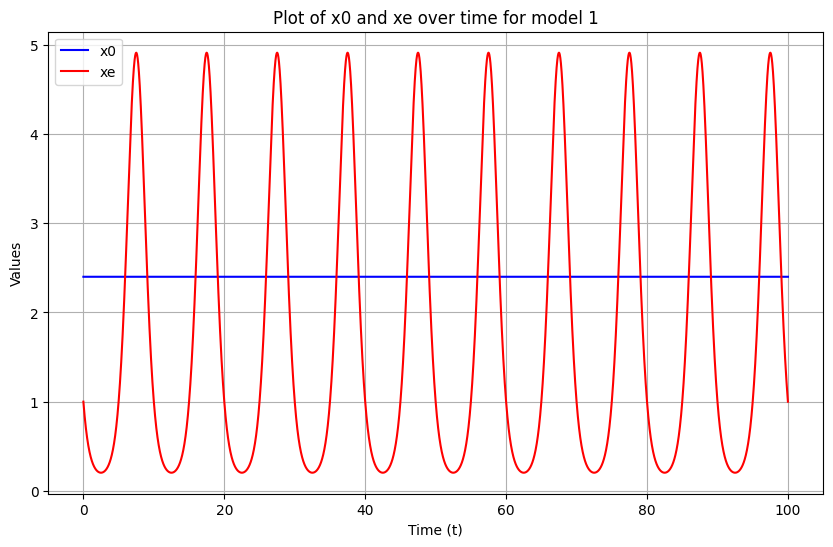

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['t'], df['x0'], label='x0', color='b')
plt.plot(df['t'], df['xe'], label='xe', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Plot of x0 and xe over time for model 1')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Architecture

For the training a 10 input sequence LSTM followed by a dense 50 input neural network,

In [ ]:
# Preprocess data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

seq_length = 10  # You can adjust this
X_train = create_sequences(train_df[['x0', 'xe']].values, seq_length)
y_train = train_df[['x0', 'xe']].iloc[seq_length:].values
X_test = create_sequences(test_df[['x0', 'xe']].values, seq_length)
y_test = test_df[['x0', 'xe']].iloc[seq_length:].values

# Define and train LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)  # 2 output nodes for x0 and xe
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


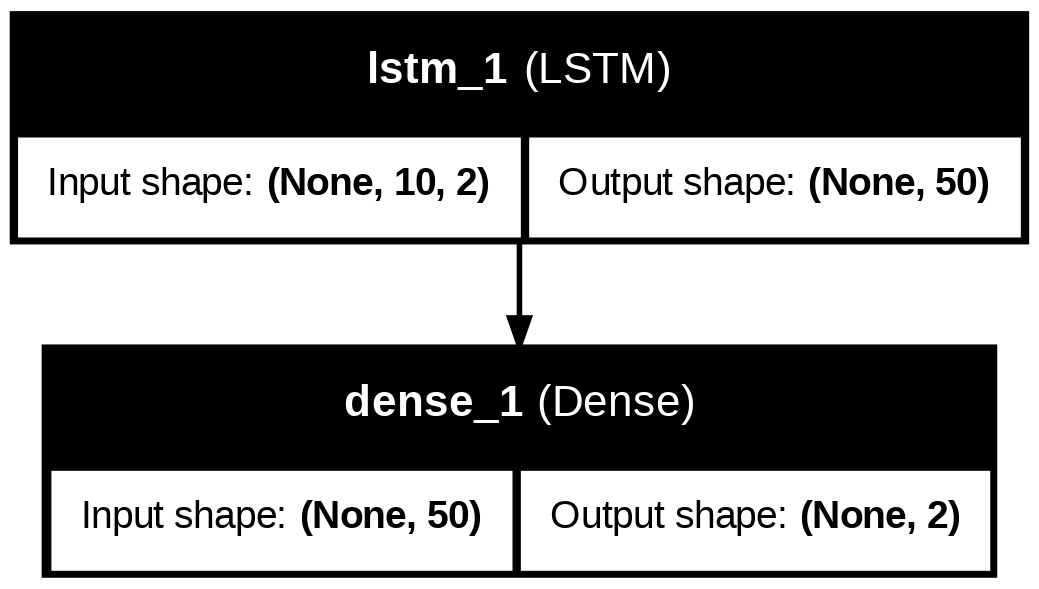

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Training

In [ ]:

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
train_forecast = model.predict(X_train)


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.1991 - val_loss: 0.0030
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.9958e-04 - val_loss: 7.9229e-04
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3113e-04 - val_loss: 5.2832e-04
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.6166e-04 - val_loss: 4.0051e-04
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Time comparison of Forecast Using Runge of order 5(4) and LSTM

In [ ]:
from scipy.integrate import solve_ivp
# Define your ODE system
def ode_system(y, t):
    # Example ODE system; replace with your actual system
    dydt = -y * np.cos(2 * np.pi * (t / 10))
    return dydt

# Initial condition and time points
y0 = [1.0]  # Example initial condition; adjust as needed
t_span = (0, 100)
t_eval = np.linspace(0, 100, len(X_test))  # Time points for which you want the solution

# Measure ODE solver time
start_time_ode = time.time()
solution = solve_ivp(ode_system, t_span, y0, t_eval=t_eval, method='RK45')
end_time_ode = time.time()
ode_time_taken = end_time_ode - start_time_ode
print(f"Time taken for numerical test forecast: {ode_time_taken:.4f} seconds")

start_time = time.time()
test_forecast = model.predict(X_test)
end_time = time.time()
test_time_taken = end_time - start_time

print(f"Time taken for test forecast: {test_time_taken:.4f} seconds")

Time taken for numerical test forecast: 0.1726 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Time taken for test forecast: 0.3670 seconds


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute regression metrics
mse = mean_squared_error(y_test, test_forecast)
mae = mean_absolute_error(y_test, test_forecast)
r2 = r2_score(y_test, test_forecast)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 0.0003
Test MAE: 0.0125
Test R²: -15820611739290635266424832.0000


# Forecast

In [ ]:
# Visualize forecast
def plot_forecast(actual, forecast,title,label1='Actual',label2='Forecast' ):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label=label1)
    plt.plot(forecast, label=label2)
    plt.title(title)
    plt.legend()
    plt.show()

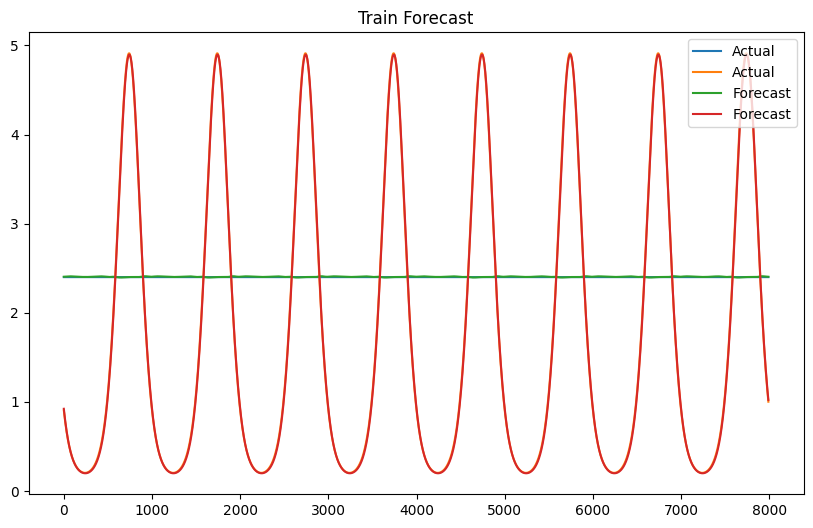

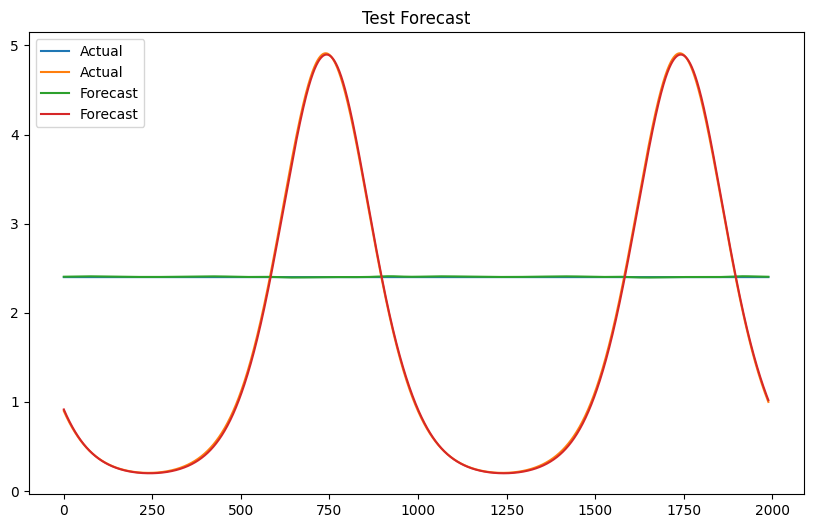

In [ ]:
plot_forecast(y_train, train_forecast, title='Train Forecast')
plot_forecast(y_test, test_forecast, title='Test Forecast')

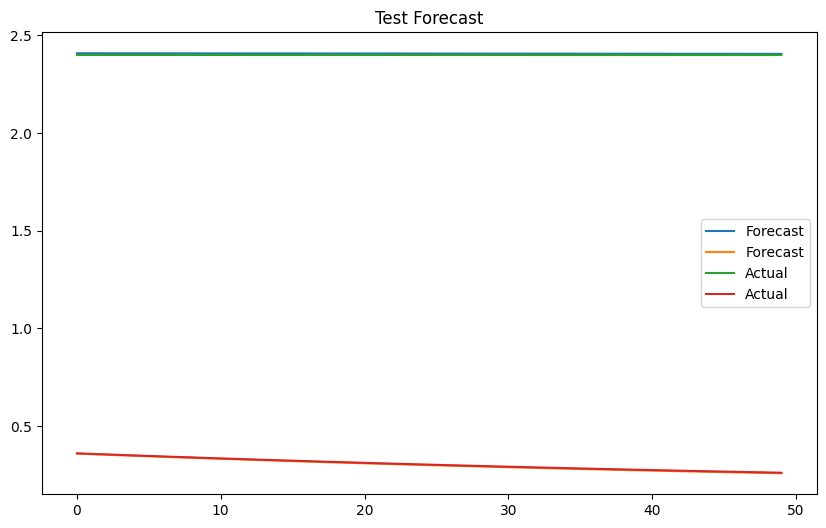

In [ ]:
# Visualize forecast
def plot_forecast(actual, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast[100:150], label='Forecast')
    plt.plot(actual[100:150], label='Actual')
    plt.title(title)
    plt.legend()
    plt.show()


plot_forecast(y_test, test_forecast, title='Test Forecast')

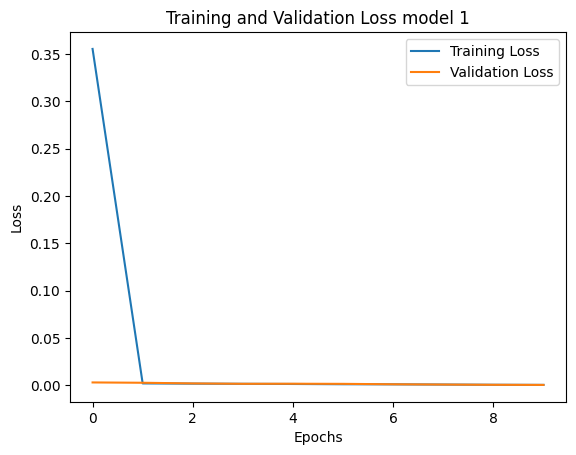

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss model 1')
plt.legend()
plt.show()

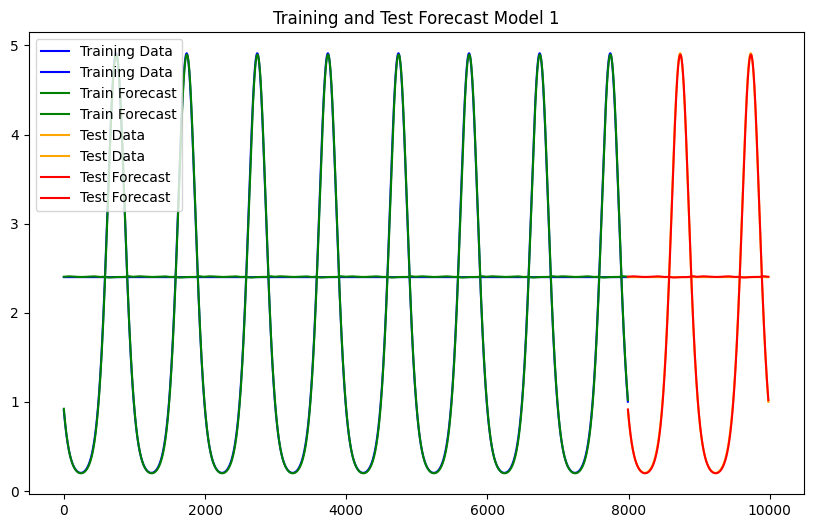

In [ ]:
def plot_forecast(train_actual, train_forecast, test_actual, test_forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_actual, label='Training Data', color='blue')
    plt.plot( train_forecast, label='Train Forecast', color='green')
    plt.plot(np.arange(len(train_actual) , len(train_actual)  + len(test_actual)), test_actual, label='Test Data', color='orange')
    plt.plot(np.arange(len(train_actual) , len(train_actual)  + len(test_forecast)), test_forecast, label='Test Forecast', color='red')
    plt.title(title)
    plt.legend()
    plt.show()
plot_forecast(y_train, train_forecast, y_test, test_forecast, title='Training and Test Forecast Model 1')
